In [18]:

import keras.backend as K
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
import time

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tqdm import tqdm

from keras.models import load_model
from keras.layers import Input
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam

# glull files
from src.utilities import data as gldata
from src.utilities import unet as glunet

# https://stackoverflow.com/questions/55350010/ive-installed-cudnn-but-error-failed-to-get-convolution-algorithm-shows-up
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [29]:


USE_CACHED_MODEL = True

# train_percentage = 1  # 1

# play with this value to increase AUC
preds_threshold = 0.5

CHECK_IMAGES = 20

SAVE_FIG = True

# Set some parameters
# image_dimension = 650 # original shape
split_dimension = 128
image_dimension = 640  # resized dimension
split_len = int(image_dimension // split_dimension)
image_channels = 3
mask_channels = 1
RGB_bits = 2047  # RGB images
mask_bits = 255  # grayscale

# train_percentage = 1  # 1
# train_percentage = 0.75  # 1
train_percentage = 0.50  # 1
# train_percentage = 0.25  # 1
# train_percentage = 0.1  # 1
# train_percentage = 0.05  # 1
# train_percentage = 0.01  # 1
# train_percentage = 0.005  # 1

# model
batch_size = 64  # 32
dropout = 0.1  # 0.1
n_filters = 16  # 16
epochs = 50  # 100
patience = 15  # 20
float_type = 'float16'
metrics = ['accuracy']  # ['accuracy']
metric_params = 'accuracy'  # 'accuracy'
loss_metrics = 'binary_crossentropy'  # 'binary_crossentropy'
loss_params = 'binary_crossentropy'  # 'binary_crossentropy'

# model medium
# batch_size = 32  # 32
# dropout = 0.1  # 0.1
# n_filters = 8  # 16
# epochs = 50  # 100
# patience = 20  # 20
# float_type = 'float16'

# model FAST
# batch_size = 8  # 32
# dropout = 0.1  # 0.1
# n_filters = 4  # 16
# epochs = 30  # 100
# patience = 10  # 20
# float_type = 'float16'

assets = 'assets/spacenet/'

# Get and resize train images and masks

parameters = gldata.get_parameters(
    epochs,
    train_percentage,
    batch_size,
    dropout,
    n_filters,
    metric_params,
    loss_params,
    float_type,
)
CACHED_MODEL_FILENAME = f'models/spacenet{parameters}.h5'
CACHED_PREDICTION_FILENAME = f'models/spacenet{parameters}_preds.pkl'
CACHED_EVALUATION_FILENAME = f'models/spacenet{parameters}_evals.pkl'


def savefig(fig, name, save=SAVE_FIG):
    if save:
        fig.savefig(
            name,
            bbox_inches='tight'
        )


ids = gldata.get_image_ids('all', train_percentage)
X_ids_train = gldata.get_image_ids('train', train_percentage)
X_ids_valid = gldata.get_image_ids('valid', train_percentage)
ids_test = gldata.get_image_ids('test', train_percentage)
ids_remainder = gldata.get_image_ids('remainder', train_percentage)

USE_X_TRAIN = True
USE_X_VALID = True
USE_X_TEST = True

print(
    f'\n\nTrain percentage ({train_percentage * 100}%): {len(ids) // 1} / {len(ids) * (1/train_percentage) // 1} \n\n')




Using pickled ids (all 50.0)% 1808 / 3616


Using pickled ids (train 50.0)% 1152 / 2305


Using pickled ids (valid 50.0)% 293 / 586


Using pickled ids (test 50.0)% 362 / 725


Using pickled ids (remainder 50.0)% 1445 / 2891



Train percentage (50.0%): 1808 / 3616.0 




In [30]:

def get_tvt(
    X_ids_train,
    X_ids_valid,
    ids_test,
    float_type,
    split_dimension=split_dimension,
    image_dimension=image_dimension,
    image_channels=image_channels,
    mask_channels=mask_channels
):

    X_train, y_train = [], []
    X_valid, y_valid = [], []
    X_test, y_test = [], []

    if USE_X_TRAIN:
        X_train, y_train = gldata.get_data(
            X_ids_train,
            split_dimension,
            image_dimension,
            image_channels,
            mask_channels,
            float_type
        )

    if USE_X_VALID:
        X_valid, y_valid = gldata.get_data(
            X_ids_valid,
            split_dimension,
            image_dimension,
            image_channels,
            mask_channels,
            float_type
        )

    if USE_X_TEST:
        X_test, y_test = gldata.get_data(
            ids_test,
            split_dimension,
            image_dimension,
            image_channels,
            mask_channels,
            float_type
        )

    return X_train, y_train, X_valid, y_valid, X_test, y_test

# Split train and valid
# TODO after this split the variable id_without_ext will be off, and also the y_train...?


# Check if training data looks all right
def check_input_images(X_train, y_train, parameters):
    for ix in range(5):
        id_without_ext = X_ids_train[ix].split('.')[0]

        start = ix * 25
        end = start + 25

        x_image = gldata.stich_images(X_train[start:end]).astype(np.float32)
        y_image = gldata.stich_images(y_train[start:end]).astype(np.float32)
        has_mask = y_image.max() > 0

        fig, ax = plt.subplots(1, 2, figsize=(20, 10))

        ax[0].imshow(x_image, interpolation='bilinear')
        # ax[0].imshow(X_train[ix, ..., 0], cmap='seismic', interpolation='bilinear')
        if has_mask:
            ax[0].contour(y_image.squeeze(), colors='k', levels=[0.5])
        ax[0].set_title(f'Satellite {id_without_ext}')

        ax[1].imshow(y_image.squeeze(), interpolation='bilinear', cmap='gray')
        ax[1].set_title(f'Buildings {id_without_ext}')

        fig_name = os.path.join(
            assets, f'{id_without_ext}_mask_comparison_{parameters}.png')
        print(f'\nSaving figure {fig_name}\n')
        savefig(fig, fig_name)

        # check 25 images
        fig, axs = plt.subplots(
            5, 10,
            sharex=True, sharey=True,
            gridspec_kw={'hspace': 0, 'wspace': 0},
            figsize=(20, 10)
        )

        fig.suptitle('Satellite with Building Mask')
        counter = start + 0
        id_without_ext = ids[ix].split('.')[0]
        for i in range(5):
            for j in range(5):
                axs[i, j].imshow(X_train[counter].astype(
                    np.float32), interpolation='bilinear')
                axs[i, j].contour(y_train[counter].astype(np.float32).squeeze(),
                                  colors='k', levels=[0.5])
                counter += 1

        counter = start + 0
        for i in range(5):
            for j in range(5, 10):
                axs[i, j].imshow(y_train[counter].astype(np.float32).squeeze(),
                                 interpolation='bilinear', cmap='gray')
                counter += 1

        for ax_row in axs:
            for ax in ax_row:
                ax.label_outer()

        fig_name = os.path.join(
            assets, f'{id_without_ext}_stiched_mask_comparison_{parameters}.png')
        print(f'\nSaving figure {fig_name}')
        savefig(fig, fig_name)


def create_model(
    split_dimension,
    image_channels,
    n_filters,
    dropout,
    metrics=metrics,
    loss=loss_metrics,
    optimizer=Adam,
    batchnorm=True
):
    input_img = Input((split_dimension, split_dimension,
                       image_channels), name='img')
    model = glunet.get_unet(input_img, n_filters=n_filters,
                            dropout=dropout, batchnorm=batchnorm)

    model.compile(
        optimizer=optimizer(),
        loss=loss,
        metrics=metrics
    )

    model.summary()

    print('model summary')

    return model


def train_cache_model(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    patience=patience,
    batch_size=batch_size,
    epochs=epochs,
    use_cached_model=USE_CACHED_MODEL,
    cached_model_filename=CACHED_MODEL_FILENAME,
    parameters=parameters
):
    if use_cached_model and os.path.exists(cached_model_filename):
        print(f'\n\nUsing cached model: {cached_model_filename}')
        model.load_weights(cached_model_filename)

    else:
        print(
            f'\n\nNo cached model found, will save as: {cached_model_filename}')

        # (glull) tutorial and documentation
        # https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
        # https://keras.io/callbacks/#modelcheckpoint
        # custom metric https://stackoverflow.com/questions/43782409/how-to-use-modelcheckpoint-with-custom-metrics-in-keras
        callbacks = [
            EarlyStopping(
                patience=patience,
                verbose=1
            ),
            ReduceLROnPlateau(
                factor=0.1, patience=3,
                min_lr=0.00001, verbose=1
            ),
            ModelCheckpoint(
                cached_model_filename, verbose=1,
                save_best_only=True, save_weights_only=True,
                monitor='val_loss',
                mode='min'

            )
        ]

        xy_train_valid = np.array([
            X_train.shape[0], y_train.shape[0], X_valid.shape[0], y_valid.shape[0]])
        if not xy_train_valid.all():
            print(
                f'\n\nError modeling: X/y_train/valid are empty {xy_train_valid}')
            exit()

        epochs = epochs
        results = model.fit(
            X_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            callbacks=callbacks,
            validation_data=(X_valid, y_valid)
        )

        plt.figure(figsize=(15, 15))
        plt.title(f"Learning curve {' '.join(parameters.split('_'))}")
        plt.plot(results.history["loss"], label="loss")
        plt.plot(results.history["val_loss"], label="val_loss")
        plt.plot(np.argmin(results.history["val_loss"]), np.min(
            results.history["val_loss"]), marker="x", color="r", label="best model")
        plt.xlabel("Epochs")
        plt.ylabel("log_loss")
        plt.legend()

        name = os.path.join(assets, f'tgs_learning_curve{parameters}.png')
        savefig(plt, name)

    return model


# Predict on train, val and test


def get_predictions(model, X_train, X_valid, X_test, cached_prediction_filename=CACHED_PREDICTION_FILENAME):
    if os.path.exists(cached_prediction_filename):
        with open(cached_prediction_filename, 'rb') as readfile:
            preds = pickle.load(readfile)

    else:
        preds_train = model.predict(X_train, verbose=1)
        preds_val = model.predict(X_valid, verbose=1)
        preds_test = model.predict(X_test, verbose=1)
        preds = {
            'train': preds_train,
            'val': preds_val,
            'test': preds_test
        }

        with open(cached_prediction_filename, 'wb') as writefile:
            pickle.dump(preds, writefile)

    return preds


def get_evaluations(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    X_test,
    y_test,
    cached_evaluation_filename=CACHED_EVALUATION_FILENAME
):

    if os.path.exists(cached_evaluation_filename):
        with open(cached_evaluation_filename, 'rb') as readfile:
            print(f'\nUsing cached eval files {cached_evaluation_filename}')
            evaluations = pickle.load(readfile)

    else:
        train_eval = model.evaluate(X_train, y_train, verbose=1)
        print(f'\nTrain eval {X_train.shape} {train_eval}')
        print('\n')

        valid_eval = model.evaluate(X_valid, y_valid, verbose=1)
        print(f'\nValid eval {X_valid.shape} {valid_eval}')
        print('\n')

        test_eval = model.evaluate(X_test, y_test, verbose=1)
        print(f'\nTest eval {X_test.shape} {test_eval}')
        print('\n')

        evaluations = {
            'train': train_eval,
            'val': valid_eval,
            'test': test_eval
        }

        with open(cached_evaluation_filename, 'wb') as writefile:
            pickle.dump(evaluations, writefile)

    return evaluations


def get_predictions_thresholds(preds, preds_threshold=preds_threshold):
    preds_train = preds['train']
    preds_val = preds['val']
    preds_test = preds['test']

    preds_train_t = (preds_train > preds_threshold).astype(np.uint8)
    preds_val_t = (preds_val > preds_threshold).astype(np.uint8)
    preds_test_t = (preds_test > preds_threshold).astype(np.uint8)

    return preds_train_t, preds_val_t, preds_test_t


def plot_sample(model, X, y, preds, binary_preds, evaluations, ix=None):
    start = ix * 25
    end = start + 25

    x_image = gldata.stich_images(X[start:end]).astype(np.float32)

    y_image = gldata.stich_images(y[start:end]).astype(np.float32)

    preds_image = gldata.stich_images(preds[start:end]).astype(np.float32)

    binary_preds_image = gldata.stich_images(
        binary_preds[start:end]).astype(np.float32)

    has_mask = y_image.max() > 0

    plt.close()

    fig, ax = plt.subplots(
        1, 4, figsize=(40, 10)
    )

    metric_names = model.metrics_names
    loss_eval = evaluations[0]
    metric_eval = [
        f'{metric_name} {metric:0.3}' for metric, metric_name in list(zip(evaluations[1:], metric_names[1:]))]
    fig.suptitle(
        f'Satellite with Building Predicted {metric_names[0]}: {loss_eval:0.3f}, metric(s): {", ".join(metric_eval)})')

    ax[0].imshow(x_image)
    if has_mask:
        ax[0].contour(y_image.squeeze(), colors='k', levels=[0.5])
    ax[0].set_title('Satellite')

    ax[1].imshow(y_image.squeeze())
    ax[1].set_title('Buildings')

    ax[2].imshow(preds_image.squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[2].contour(y_image.squeeze(), colors='k', levels=[0.5])
    ax[2].set_title('Buildings Predicted')

    ax[3].imshow(binary_preds_image.squeeze(), vmin=0, vmax=1)
    if has_mask:
        ax[3].contour(y_image.squeeze(), colors='k', levels=[0.5])
    ax[3].set_title('Buildings Predicted binary')

    return fig


def output_train_val_test_images(
    model,
    X_train,
    y_train,
    X_valid,
    y_valid,
    X_test,
    y_test,
    preds,
    evaluations,
    preds_threshold=preds_threshold,
    split_len=split_len,
    parameters=parameters
):

    dirpath = os.path.join(assets, parameters)
    if not os.path.exists(dirpath):
        os.mkdir(dirpath)

    preds_train = preds['train']
    preds_val = preds['val']
    preds_test = preds['test']

    preds_train_t, preds_val_t, preds_test_t = get_predictions_thresholds(
        preds, preds_threshold)

    train_eval = evaluations['train']
    val_eval = evaluations['val']
    test_eval = evaluations['test']

    # Check if training data looks all right
    if USE_X_TRAIN:
        train_min = min(CHECK_IMAGES, int(y_train.shape[0] / (split_len ** 2)))
        print(f'outputing predicted train images {train_min}')
        for i in tqdm(range(train_min), total=train_min):
            fig_train = plot_sample(
                model, X_train, y_train, preds_train, preds_train_t, train_eval, ix=i)
            name = f'{dirpath}/spacenet_train_predicted_fig_{i}_{parameters}.png'
            savefig(fig_train, name)

    # Check if validation data looks all right
    if USE_X_VALID:
        valid_min = min(CHECK_IMAGES, int(y_valid.shape[0] / (split_len ** 2)))
        print(f'outputing predicted valid images {valid_min}')
        for i in tqdm(range(valid_min), total=valid_min):
            fig_val = plot_sample(
                model, X_valid, y_valid, preds_val, preds_val_t, val_eval, ix=i)
            name = f'{dirpath}/spacenet_val_predicted_fig_{i}_{parameters}.png'
            savefig(fig_val, name)

    # Check tests
    if USE_X_TEST:
        test_min = min(CHECK_IMAGES, int(y_test.shape[0] / (split_len ** 2)))
        print(f'outputing predicted test images {test_min}')
        for i in tqdm(range(test_min), total=test_min):
            fig_val = plot_sample(
                model, X_test, y_test, preds_test, preds_test_t, test_eval, ix=i)
            name = f'{dirpath}/spacenet_test_predicted_fig_{i}_{parameters}.png'
            savefig(fig_val, name)




In [34]:
def main_fast(X_train, y_train, X_valid, y_valid, X_test, y_test, train_percentage):

    total_time_start = time.time()
    
    # single
    batch_size = 64  # 32
    dropout = 0.1  # 0.1
    n_filters = 16  # 16
    epochs = 50  # 100
    patience = 15  # 20
    float_type = 'float16'

    # super fast
#     batch_size = 128  # 32
#     dropout = 0.1  # 0.1
#     n_filters = 4  # 16
#     epochs = 15  # 100
#     patience = 5  # 20
#     float_type = 'float16'

    # metrics
    # _epochs15_train0.5_batch128_dropout0.1_n_filters4_metric-accuracy-iou-dice-smooth_loss-iou-coef-loss_float16
    metrics = ['accuracy']  # ['accuracy']
    metric_params = 'accuracy'  # 'accuracy'
    loss_metrics = 'binary_crossentropy'  # 'binary_crossentropy'
    loss_params = 'binary_crossentropy'  # 'binary_crossentropy'

    # alternate metrics
#     metrics = ['accuracy', glunet.iou_coef,
#                glunet.dice_coef_smooth]  # ['accuracy']
#     metric_params = 'accuracy-iou-dice-smooth'  # 'accuracy'
#     loss_metrics = glunet.iou_coef_loss  # 'binary_crossentropy'
#     loss_params = 'iou-coef-loss'  # 'binary_crossentropy'
    
    
    # begin training
    model_params = []

    train_model_start = time.time()

    parameters = gldata.get_parameters(
        epochs,
        train_percentage,
        batch_size,
        dropout,
        n_filters,
        metric_params,
        loss_params,
        float_type,
    )
    CACHED_MODEL_FILENAME = f'models/spacenet{parameters}.h5'
    CACHED_PREDICTION_FILENAME = f'models/spacenet{parameters}_preds.pkl'
    CACHED_EVALUATION_FILENAME = f'models/spacenet{parameters}_evals.pkl'

    print(f'\n\nparameters:\n{parameters}\n\n')

    # check_input_images(X_train, y_train, parameters)

    model = create_model(
        split_dimension,
        image_channels,
        n_filters,
        dropout,
        metrics,
        loss_metrics
    )

    model = train_cache_model(
        model,
        X_train,
        y_train,
        X_valid,
        y_valid,
        patience,
        batch_size,
        epochs,
        USE_CACHED_MODEL,
        CACHED_MODEL_FILENAME,
        parameters
    )

    train_model_end = time.time() - train_model_start

    predict_output_image_start = time.time()

    preds = get_predictions(
        model,
        X_train,
        X_valid,
        X_test,
        CACHED_PREDICTION_FILENAME
    )

    evaluations = get_evaluations(
        model,
        X_train,
        y_train,
        X_valid,
        y_valid,
        X_test,
        y_test,
        CACHED_EVALUATION_FILENAME
    )

    output_train_val_test_images(
        model,
        X_train,
        y_train,
        X_valid,
        y_valid,
        X_test,
        y_test,
        preds,
        evaluations,
        preds_threshold,
        split_len,
        parameters
    )

    predict_output_image_end = time.time() - predict_output_image_start

    total_time_end = time.time() - total_time_start

    prefix = f'minutes; train: {train_model_end // 60}, predict/output: {predict_output_image_end // 60}'

    print(f'\n\nparameters:\n{parameters}\n')

    model_params.append(
        (total_time_end // 60, prefix, CACHED_PREDICTION_FILENAME))

    return model, model_params, preds, evaluations


In [22]:
os.path.exists('data/spacenet/AOI_2_Vegas_Train/RGB-PanSharpen_resize640_split128_bit2047_float16/')

True

In [23]:
percentage50 = 0.5

ids50 = gldata.get_image_ids('all', percentage50)
X_ids_train50 = gldata.get_image_ids('train', percentage50)
X_ids_valid50 = gldata.get_image_ids('valid', percentage50)
ids_test50 = gldata.get_image_ids('test', percentage50)
ids_remainder50 = gldata.get_image_ids('remainder', percentage50)

X_train50, y_train50, X_valid50, y_valid50, X_test50, y_test50 = get_tvt(
X_ids_train50, X_ids_valid50, ids_test50, float_type)


  0%|          | 0/1152 [00:00<?, ?it/s]


Using pickled ids (all 50.0)% 1808 / 3616


Using pickled ids (train 50.0)% 1152 / 2305


Using pickled ids (valid 50.0)% 293 / 586


Using pickled ids (test 50.0)% 362 / 725


Using pickled ids (remainder 50.0)% 1445 / 2891

Using preprocessed _resize640_split128_bit2047_float16 images

Examining images (use preprocess) 28800

Example path: data/spacenet/AOI_2_Vegas_Train/RGB-PanSharpen_resize640_split128_bit2047_float16/RGB-PanSharpen_AOI_2_Vegas_img4602_part_*.tif



 13%|█▎        | 153/1152 [00:46<05:02,  3.30it/s]


 26%|██▋       | 304/1152 [01:32<04:17,  3.29it/s]


 39%|███▉      | 455/1152 [02:18<03:28,  3.35it/s]


 53%|█████▎    | 606/1152 [03:04<02:43,  3.34it/s]


 66%|██████▌   | 757/1152 [03:50<01:59,  3.31it/s]


 79%|███████▉  | 908/1152 [04:36<01:12,  3.34it/s]


 92%|█████████▏| 1058/1152 [05:21<00:28,  3.33it/s]


100%|██████████| 1152/1152 [05:49<00:00,  3.29it/s]

  0%|          | 0/293 [00:00<?, ?it/s]


Done getting images!
Using preprocessed _resize640_split128_bit2047_float16 images

Examining images (use preprocess) 7325

Example path: data/spacenet/AOI_2_Vegas_Train/RGB-PanSharpen_resize640_split128_bit2047_float16/RGB-PanSharpen_AOI_2_Vegas_img970_part_*.tif



 53%|█████▎    | 156/293 [00:47<00:41,  3.27it/s]


100%|██████████| 293/293 [01:30<00:00,  3.25it/s]

  0%|          | 0/362 [00:00<?, ?it/s]


Done getting images!
Using preprocessed _resize640_split128_bit2047_float16 images

Examining images (use preprocess) 9050

Example path: data/spacenet/AOI_2_Vegas_Train/RGB-PanSharpen_resize640_split128_bit2047_float16/RGB-PanSharpen_AOI_2_Vegas_img5753_part_*.tif



 43%|████▎     | 156/362 [00:47<01:02,  3.30it/s]


 86%|████████▌ | 310/362 [01:35<00:16,  3.19it/s]


100%|██████████| 362/362 [01:51<00:00,  3.24it/s]


Done getting images!


In [ ]:
# percentage25 = 0.25

# ids25 = gldata.get_image_ids('all', percentage25)
# X_ids_train25 = gldata.get_image_ids('train', percentage25)
# X_ids_valid25 = gldata.get_image_ids('valid', percentage25)
# ids_test25 = gldata.get_image_ids('test', percentage25)
# ids_remainder25 = gldata.get_image_ids('remainder', percentage25)

# X_train25, y_train25, X_valid25, y_valid25, X_test25, y_test25 = get_tvt(
# X_ids_train25, X_ids_valid25, ids_test25, float_type)


In [ ]:
# train_percentage1 = 0.1

# ids1 = gldata.get_image_ids('all', train_percentage1)
# X_ids_train1 = gldata.get_image_ids('train', train_percentage1)
# X_ids_valid1 = gldata.get_image_ids('valid', train_percentage1)
# ids_test1 = gldata.get_image_ids('test', train_percentage1)
# ids_remainder1 = gldata.get_image_ids('remainder', train_percentage1)

# X_train1, y_train1, X_valid1, y_valid1, X_test1, y_test1 = get_tvt(
# X_ids_train1, X_ids_valid1, ids_test1, float_type)



parameters:
_epochs50_train0.5_batch64_dropout0.1_n_filters16_metric-accuracy_loss-binary_crossentropy_float16


Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img (InputLayer)                (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_77 (Conv2D)              (None, 128, 128, 16) 448         img[0][0]                        
__________________________________________________________________________________________________
batch_normalization_73 (BatchNo (None, 128, 128, 16) 64          conv2d_77[0][0]                  
__________________________________________________________________________________________________
activation_73 (Activation)      (None, 128, 128, 16) 0           batch_norma

28800/28800 [==============================] - 27s 932us/step

Train eval (28800, 128, 128, 3) [0.10698115146770659, 0.95419842004776]


7325/7325 [==============================] - 7s 924us/step

Valid eval (7325, 128, 128, 3) [0.11081349017371904, 0.954190194606781]


9050/9050 [==============================] - 8s 917us/step

Test eval (9050, 128, 128, 3) [0.0945599298615482, 0.9563590884208679]





  0%|          | 0/20 [00:00<?, ?it/s]

outputing predicted train images 20



100%|██████████| 20/20 [00:14<00:00,  1.34it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

outputing predicted valid images 20



100%|██████████| 20/20 [00:14<00:00,  1.33it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

outputing predicted test images 20



100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


NameError: name 'read_files_end' is not defined

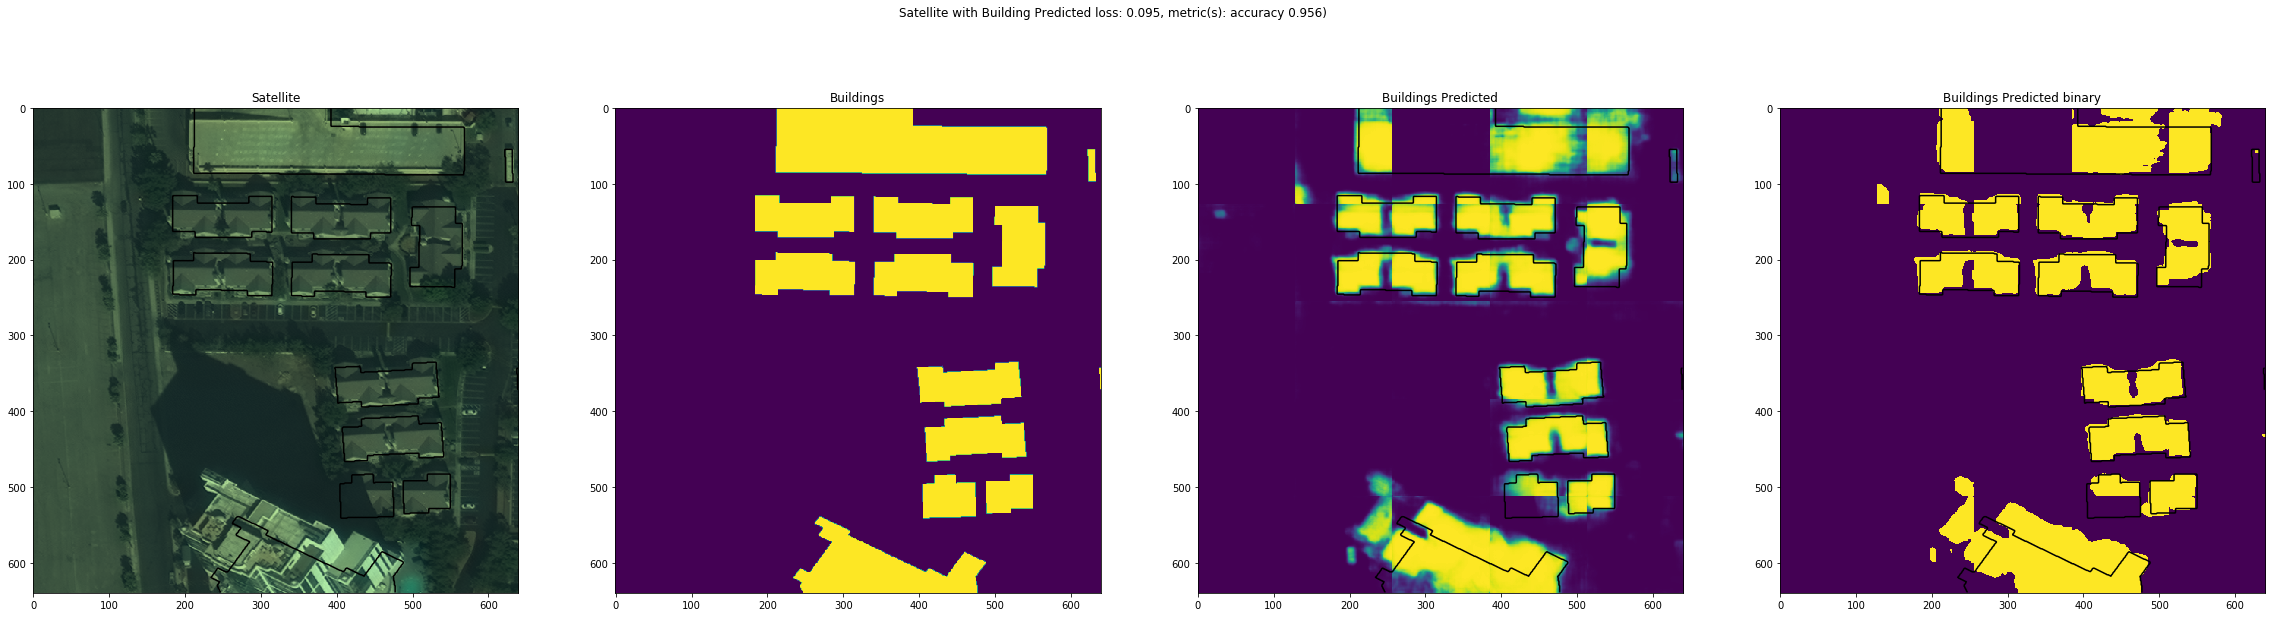

In [32]:
#_epochs50_train0.5_batch64_dropout0.1_n_filters32_float16
model50, model_params50, preds50, evaluations50 = main_fast(X_train50, y_train50, X_valid50, y_valid50, X_test50, y_test50, percentage50)


In [ ]:
# model25, model_params25, preds25, evaluations25 = main_fast(X_train25, y_train25, X_valid25, y_valid25, X_test25, y_test25)


In [ ]:
# model1, model_params1, preds1, evaluations1 = main_fast(X_train1, y_train1, X_valid1, y_valid1, X_test1, y_test1)
